## 範例
參考 `train.py` 實現的訓練模型程式碼範例


In [1]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [2]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

     |████████████████████████████████| 317kB 6.5MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive/keras-yolo3


In [7]:
import os
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
    print("Model doesn't exist, downloading...")
    #os.system("wget https://pjreddie.com/media/files/yolov3.weights")
    print("Converting yolov3.weights to yolo.h5...")
    os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
    print("done")
else:
    print("Model exist")

Model exist


In [0]:
# 直接下載 VOC2007 的資料集作為範例
import os
if not os.path.exists("VOCdevkit"):
    #os.system("wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar") # 下載 VOC 資料集
    os.system("tar xvf VOCtrainval_06-Nov-2007.tar") # 解壓縮資料集，會花幾分鐘
else:
    print("data exists")

data exists


以下的程式碼負責把下載下來的 Pascal VOC 資料集轉換為訓練模型時需要的格式，直接引用 https://github.com/qqwweee/keras-yolo3/blob/master/voc_annotation.py ，調整了一部分程式碼，讓我們只 sample 前 100 張圖片來做示範，在 colab 中會花一些時間跑完

In [0]:
import os
if not os.path.exists("2007_train.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
    import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
    from os import getcwd

    sets=[('2007', 'train'), ('2007', 'val')]

  # Pascal VOC 的資料類別
    classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

  # 把 annotation 轉換訓練時需要的資料形態
def convert_annotation(year, image_id, list_file):
    in_file = open('VOCdevkit/VOC%s/Annotations/%s.xml'%(year, image_id))
    tree=ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

    wd = "."

    for year, image_set in sets:
        image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
        annotation_path = '%s_%s.txt'%(year, image_set)
        list_file = open(annotation_path, 'w')
        print("save annotation at %s" % annotation_path)
        for image_id in image_ids[:100]: # 只處理 100 張圖片來做範例
            list_file.write('%s/VOCdevkit/VOC%s/JPEGImages/%s.jpg'%(wd, year, image_id))
            convert_annotation(year, image_id, list_file)
            list_file.write('\n')
        list_file.close()

In [4]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.


In [0]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重，注意這部分多了一個 `-w` 的參數，可以參考 https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242 以及 https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 理解其中差別

In [8]:
if not os.path.exists("model_data/yolo_weights.h5"):
    print("Converting pretrained YOLOv3 weights for training")
    os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
    print("Pretrained weights exists")

Pretrained weights exists


In [10]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

annotation_path = '2007_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Create YOLOv3 model with 9 anchors and 2 classes.
Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.
Train on 235 samples, val on 26 samples, with batch size 16.
Epoch 1/50
14/14 [==============================] - 111s 8s/step - loss: 6623.4039 - val_loss: nan

Epoch 2/50
14/14 [==============================] - 20s 1s/step - loss: 6078.6731 - val_loss: nan
Epoch 3/50
14/14 [==============================] - 17s 1s/step - loss: 5600.3249 - val_loss: nan
Epoch 4/50
14/14 [==============================] - 17s 1s/step - loss: 5162.7482 - val_loss: nan
Epoch 5/50
14/14 [==============================] - 17s 1s/step - loss: 4766.4735 - val_loss: nan
Epoch 6/50
14/14 [==============================] - 17s 1s/step - loss: 4406.4942 - val_loss: nan
Epoch 7/50
14/14 [==============================] - 17s 1s/step - loss: 4081.0903 - val_loss: nan
Epoch 8/50
14/14 [==============================] - 17s 1s/step - loss: 3785.8694 - val_loss: nan
Epoch 9/50
14

In [0]:
from PIL import Image
image = Image.open('/content/gdrive/My Drive/keras-yolo3/VOCdevkit/VOC2007/JPEGImages/raccoon-33.jpg') 
image2 = Image.open('/content/gdrive/My Drive/keras-yolo3/test1.jpg')

In [16]:
from yolo import YOLO
import os
print(os.getcwd())
yolo_model = YOLO(model_path='logs/000/' + 'trained_weights_final.h5', classes_path='model_data/voc_classes.txt')
r_image = yolo_model.detect_image(image)
r_image2 = yolo_model.detect_image(image2)

/content/gdrive/My Drive/keras-yolo3
logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (122, 17) (598, 843)
2.870409701999961
(416, 416, 3)
Found 2 boxes for img
raccoon 0.38 (60, 8) (256, 177)
kangaroo 0.92 (70, 14) (273, 166)
0.04356865800036758


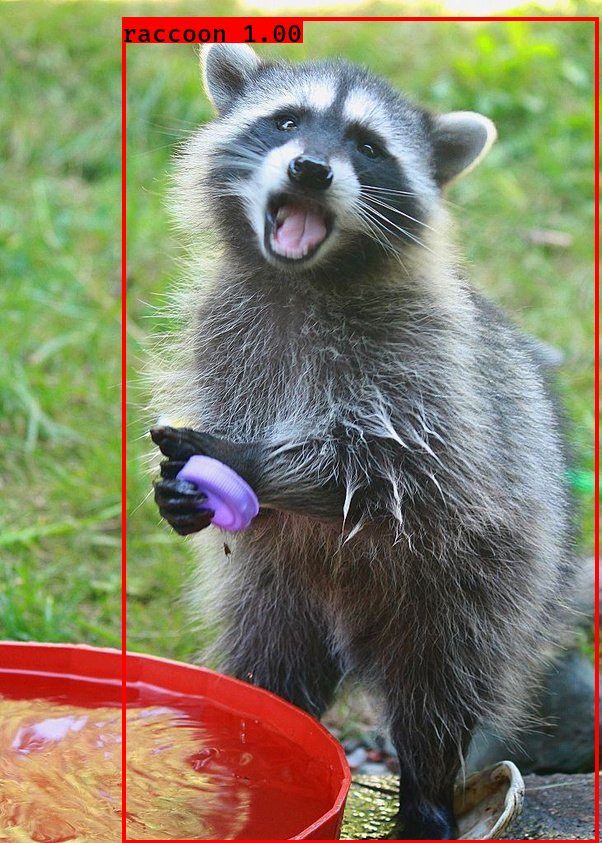

In [13]:
r_image

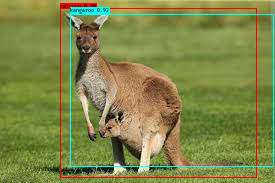

In [17]:
r_image2

In [14]:
with open("2007_train.txt", "r") as f:
    d = f.readlines()
d

['VOCdevkit/VOC2007/JPEGImages/00001.jpg 233,89,386,262,0 134,105,341,253,0\n',
 'VOCdevkit/VOC2007/JPEGImages/00002.jpg 156,114,240,309,0 222,117,415,306,0\n',
 'VOCdevkit/VOC2007/JPEGImages/00003.jpg 99,5,403,279,0\n',
 'VOCdevkit/VOC2007/JPEGImages/00005.jpg 508,213,843,466,0\n',
 'VOCdevkit/VOC2007/JPEGImages/00007.jpg 273,24,603,301,0\n',
 'VOCdevkit/VOC2007/JPEGImages/00009.jpg 43,135,237,348,0\n',
 'VOCdevkit/VOC2007/JPEGImages/00010.jpg 9,116,653,600,0 52,74,540,569,0 1,125,121,599,0\n',
 'VOCdevkit/VOC2007/JPEGImages/00013.jpg 223,87,428,355,0 62,114,596,399,0\n',
 'VOCdevkit/VOC2007/JPEGImages/00014.jpg 381,27,620,308,0 283,154,422,305,0 236,93,372,214,0 4,156,326,318,0\n',
 'VOCdevkit/VOC2007/JPEGImages/00016.jpg 91,15,565,415,0\n',
 'VOCdevkit/VOC2007/JPEGImages/00018.jpg 221,1,478,281,0\n',
 'VOCdevkit/VOC2007/JPEGImages/00019.jpg 174,74,285,358,0 374,159,598,396,0\n',
 'VOCdevkit/VOC2007/JPEGImages/00021.jpg 300,194,640,371,0 184,263,506,399,0\n',
 'VOCdevkit/VOC2007/JPEG